# Demo for generating the focal maps in multiple scanns

In [ ]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

In [ ]:
# create the folder to save the stacks
import os
from timeit import default_timer as timer

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    else:
        print('path existed')

In [ ]:
from skimage.util import img_as_ubyte

def imgFormat(img):
    if img.dtype != 'uint8':
        img = img_as_ubyte(image)
    return img

# rescale the image for comparing
def rescaleIMG(img, MIN, MAX):
    temp = np.interp(img, (img.min(), img.max()), (MIN, MAX))
    return temp

def rescale_01(arr):
    """Rescale image into [0, 1]"""
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)
    return scaled_arr

In [ ]:
# various blur detectors
# input patch-uint8

import numpy as np
from skimage import filters
import os
import cv2

# brenner detector
def brenner(img):
    
    imgMat = imgFormat(img)
    imgMat = rescale_01(imgMat)
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    # score = score/10

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source = np.sum(tmp**2)
    source = np.sqrt(source)

    return source

# laplacian
# laplacian
def  laplacian(img):

    resLap = cv2.Laplacian(np.uint8(img), cv2.CV_8U)  # adapt to the images, ddid not change the distributions
    score = resLap.var()
    return score

# SMD
def SMD(img):

    f = imgFormat(img)
    f = rescale_01(imgMat)

    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    # score=score/100
    return score

# SMD2
def SMD2(img):

    imgMat = imgFormat(img)
    imgMat = rescale_01(imgMat)
    
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)
    
    return score

# Vollath
def Vollath(img):

    f = img
    source = 0
    x,y = f.shape
    for i in range(x-1):
        for j in range(y):
            source += f[i,j]*f[i+1,j]
    source = source - x*y*np.mean(f)
    return source

In [ ]:
# multiple scans for one image with quality detectors.
# input: stack num, slice num, image, step, windowsize, metric: indicate the metric for detecting

import numpy as np
from skimage import filters
import os
import cv2

# one image
def slidingStackQuality(stackNum, sliceNum, image, stepArray, windowSize, savedPath, metric):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        feaMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                
                #########
                if metric == 'std':
                    # Roy. calculate the std
                    tempPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                    
                elif metric == 'brenner':
                    # print('cal robert', tPatch.shape, tPatch.min(), tPatch.max())
                    tempPatch = np.ones((tPatch.shape)) * np.round(brenner(tPatch), 2)
                    # print('robert mean:',tempPatch.mean())
                    
                elif metric == 'laplacian':
                    tempPatch = np.ones((tPatch.shape)) * np.round(laplacian(tPatch), 2)
                    
                elif metric == 'tenengrad':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Tenengrad(tPatch), 2)
                    # print('raw tenengrad:', np.unique(tempPatch))
                    
                elif metric == 'SMD':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD(tPatch), 2)
                    
                elif metric == 'SMD2':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD2(tPatch), 2)
                    
                elif metric == 'Variance':
                    tempPatch = np.ones((tPatch.shape)) * Variance(tPatch)
                    
                    
                elif metric == 'Vollath':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Vollath(tPatch), 2)
                
                #########
                feaMap[y:y + windowSize[1], x:x + windowSize[0]] = tempPatch + feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                
#         focalStack.append(stdMap)       
        # focalStack.append(feaMap[padH:, padW:])  # crop the feature map back 
        focalStack.append(feaMap)
    
                           
    fMax = np.max(np.asarray(focalStack), axis=0)
    # plt.imshow(fMax, cmap='gray')
                           
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)
    print('save sucessfully', sliceNum, tempPath)

In [ ]:
# read in the raw image

image = np.load('../data/raw/rawGray15.npy')
print(image.shape)

In [ ]:
# parameters for feature map

# step size
# stepArray = [8, 10]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

# window size
(winW, winH) = (64*2, 64*2)

# pad parameters
(padW, padH) = (0, winH)

# saved path
# metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'SMD', 'SMD2', 'Variance', 'Vollath']  # brenner, SMD, SMD2, Vollath is slow
metric = 'SMD'

savedPath = '../data/interim/focalMap/' + str(metric)  # change into the customer path
mkdir(savedPath)

# target data
# targetStack = val_norm_pad
# targetStack = train_norm_pad
targetStack = image 
# targetStack = targetStack[:1,...] # test on one stack
print(targetStack.shape, targetStack.max())

In [ ]:
# calculate the stack in metrics

start = timer()
for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStackQuality(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath, metric = metric):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 
                
end = timer()
print(str(metric), end-start)

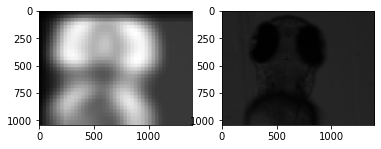

In [18]:
# compare the results with original pic

tempScan =  np.load('stdMap.npy')

# visualzie the results
plt.subplot(1,2,1)
plt.imshow(tempScan, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(image, cmap='gray')
plt.show()

# Demo for the focal plane sensitivity

In [ ]:
# various blur detectors
# input patch-uint8

import numpy as np
from skimage import filters
import os
import cv2
import pywt

# brenner detector
def brenner(img):
    
    imgMat = imgFormat(img)
    imgMat = rescale_01(imgMat)
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source = np.sum(tmp**2)
    source = np.sqrt(source)

    return source

# laplacian
# laplacian
def  laplacian(img):

    resLap = cv2.Laplacian(np.uint8(img), cv2.CV_8U)  # adapt to the images, did not change the distributions
    score = resLap.var()
    return score

# SMD
def SMD(img):

    f = imgFormat(img)
    f = rescale_01(imgMat)
    
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    return score

# SMD2
def SMD2(img):

    f = imgFormat(img)
    f = rescale_01(imgMat)
    
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)
    
    return score

# Vollath
def Vollath(img):

    f = img
    source = 0
    x,y = f.shape
    for i in range(x-1):
        for j in range(y):
            source += f[i,j]*f[i+1,j]
    source = source - x*y*np.mean(f)
    return source

def DWT(img):
    # Compute the DWT coefficients
    coeffs = pywt.wavedec2(img, 'haar', level=5)

    # Extract the high-frequency sub-bands
    subbands = coeffs[1:]

    # Calculate the energy of each sub-band
    energies = []
    for subband in subbands:
        # Convert the sub-band tuple to a 2D matrix
        subband = np.asarray(subband)
        # Calculate the energy of the sub-band
        energy = (subband * subband).sum()
        energies.append(energy)
        
    return np.asarray(energies).sum()

# rescale the image for comparing
def rescaleIMG(img, MIN, MAX):
    temp = np.interp(img, (img.min(), img.max()), (MIN, MAX))
    return temp

In [ ]:
# target

scoreStack = []

base_img  = imgStack[0,...]  # first is baseline

for i in range(imgStack.shape[0]):
    
    tempImg = imgStack[i,...][startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
    
    # brenner
    brenner1 = brenner(base_img)
    brenner2 = brenner(tempImg)
    score1 = np.abs(brenner1-brenner2)/brenner1
    # print('brenner:', brenner1, brenner2, np.abs(brenner1-brenner2)/brenner1)

    # tenengrad
    tenengrad1 = Tenengrad(base_img)
    tenengrad2 = Tenengrad(tempImg)
    score2 = np.abs(tenengrad1-tenengrad2)/tenengrad1
    # print('tenengrad:', tenengrad1, tenengrad2, np.abs(tenengrad1-tenengrad2)/tenengrad1)

    # Laplacian
    laplacian1 = laplacian(base_img)
    laplacian2 = laplacian(tempImg)
    score3 = np.abs(laplacian1-laplacian2)/laplacian1
    # print('laplacian:', laplacian1, laplacian2, np.abs(laplacian1-laplacian2)/laplacian1)

    # SMD
    SMD_1 = SMD(base_img)
    SMD_2 = SMD(tempImg)
    score4 = np.abs(SMD_1-SMD_2)/SMD_1
    # print('SMD:', SMD_1, SMD_2, np.abs(SMD_1-SMD_2)/SMD_1)

    # SMD2
    SMD2_1 = SMD2(base_img)
    SMD2_2 = SMD2(tempImg)
    score5 = np.abs(SMD2_1-SMD2_2)/SMD2_1
    # print('SMD2:', SMD2_1, SMD2_2, np.abs(SMD2_1-SMD2_2)/SMD2_1)

    # Variance
    Variance1 = Variance(base_img)
    Variance2 = Variance(tempImg)
    score6 = np.abs(Variance1-Variance2)/Variance1
    # print('Variance:', Variance1, Variance2, np.abs(Variance1-Variance2)/Variance1)

    # Vollath
    Vollath1 = Vollath(base_img)
    Vollath2 = Vollath(tempImg)
    score7 = np.abs(Vollath1-Vollath2)/Vollath1
    # print('Vollath:', Vollath1, Vollath2, np.abs(Vollath1-Vollath2)/Vollath1)

    # std
    std1 = np.std(base_img)
    std2 = np.std(tempImg)
    score8 = np.abs(std1-std2)/std1
    # print('std:', std1, std2, np.abs(std1-std2)/std1)
    
    # entropy score
    entropy1 = calEntropy(base_img, 5)
    entropy2 = calEntropy(tempImg, 5)
    score9 = np.abs(entropy1-entropy2)/entropy1
    
    # DWT
    dwt1 = DWT(base_img)
    dwt2 = DWT(tempImg)
    score10 = np.abs(dwt1-dwt2)/dwt1
    
    # slice score
    tempScore = [score1, score2, score3, score4, score6, score7, score8, score9, score10]  # don't take score 5, SMD
    scoreStack.append(tempScore)

scoreStack = np.asarray(scoreStack)

In [ ]:
# rescale the score data

scoreScale = np.interp(scoreStack, (scoreStack.min(), scoreStack.max()), (0, 1))
print(scoreScale.shape,scoreScale.max())